<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/9x.ml_highspeed_networks/1.Training-and-testing-a-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install livelossplot

In [16]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


import pickle # To save the model
from functools import partial
import random



# The following is to be able to mount Google Drive
from google.colab import drive


# We import a function I prepared for you in the course library
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/neural_network_tools.py
from visualization import plot_conf_mat
from neural_network_tools import enforce_reproducibility, make_sequential_model, train_model



from typing import List


import os
from os.path import isfile

--2025-11-15 00:11:53--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13023 (13K) [text/plain]
Saving to: ‘visualization.py.1’

visualization.py.1  100%[===================>]  12.72K  --.-KB/s    in 0.001s  

2025-11-15 00:11:53 (16.2 MB/s) - ‘visualization.py.1’ saved [13023/13023]

--2025-11-15 00:11:53--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/neural_network_tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... co

# Download the dataset and train/test split

Load the dataset

In [3]:
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/fulldataset.csv


--2025-11-15 00:10:29--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/lowdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261162 (255K) [text/plain]
Saving to: ‘lowdataset.csv’

lowdataset.csv      100%[===================>] 255.04K  --.-KB/s    in 0.01s   

2025-11-15 00:10:29 (23.0 MB/s) - ‘lowdataset.csv’ saved [261162/261162]

--2025-11-15 00:10:29--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/9x.ml_highspeed_networks/highdataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443

In [4]:
# Read the full dataset
full_df = pd.read_csv('fulldataset.csv')

# Remove the timestamp, which does not have predictive importance
full_df = full_df.drop(columns=["time"])

In [5]:
full_df.head()

,L1-dcache-load-misses,L1-dcache-loads,L1-dcache-stores,L1-icache-load-misses,LLC-load-misses,LLC-loads,LLC-store-misses,LLC-stores,branch-load-misses,branch-misses,...,instructions,minor-faults,node-load-misses,node-loads,node-store-misses,node-stores,page-faults,ref-cycles,task-clock,label
0,1836848.0,190327023.0,116151881.0,31680.0,301.0,272831.0,251.0,155393.0,171640.0,172007.0,...,614259959.0,0.0,169.0,150.0,50.0,213.0,0.0,259473178.0,100.265909,0
1,1855641.0,190782590.0,116159726.0,31550.0,288.0,273045.0,259.0,154536.0,173760.0,173161.0,...,614006400.0,0.0,175.0,125.0,50.0,238.0,0.0,259522865.0,100.276024,0
2,1856373.0,190688064.0,116229597.0,30507.0,251.0,272370.0,251.0,154825.0,170987.0,170923.0,...,614749577.0,0.0,257.0,94.0,25.0,213.0,0.0,259533231.0,100.281822,0
3,1855415.0,190785345.0,116289893.0,32535.0,226.0,273049.0,251.0,154438.0,170998.0,170960.0,...,614927834.0,0.0,157.0,138.0,13.0,226.0,0.0,259571508.0,100.270504,0
4,1844978.0,190653473.0,116246239.0,31360.0,363.0,270856.0,259.0,154519.0,172861.0,172986.0,...,614366676.0,0.0,263.0,489.0,50.0,238.0,0.0,259490859.0,100.270495,0


In [6]:
print("samples and columns", full_df.shape)
print("Possible labels ", np.unique(full_df['label']) )

samples and columns (5824, 32)
Possible labels  [0 1 2]


In [7]:
# The following line should be the same as the one in the "training and testing"
# notebook
features_to_keep = ['L1-dcache-load-misses', 'L1-dcache-loads', 'L1-dcache-stores',
       'L1-icache-load-misses', 'LLC-load-misses', 'LLC-loads',
       'LLC-store-misses', 'LLC-stores', 'branch-load-misses', 'branch-misses',
       'branches', 'bus-cycles', 'cache-misses', 'cache-references',
       'context-switches', 'cpu-clock', 'cycles', 'dTLB-load-misses',
       'dTLB-store-misses', 'dTLB-stores', 'iTLB-load-misses', 'iTLB-loads',
       'instructions', 'minor-faults', 'node-load-misses', 'node-loads',
       'node-store-misses', 'node-stores', 'page-faults', 'ref-cycles',
       'task-clock']

print("Among all features, we only keep ",len(features_to_keep))



Among all features, we only keep  31


In [8]:
columns_to_keep = features_to_keep.copy()
columns_to_keep.append('label')
df = full_df[columns_to_keep]
data = df.to_numpy()

train, test = train_test_split(data, test_size=0.2, shuffle=True, random_state=1 )

# Pre-processing

In [9]:
# We separate the last column in
train_x, train_y = np.hsplit(train, [train.shape[1] - 1])
train_y = train_y.reshape(-1).astype(int)

test_x, test_y = np.hsplit(test, [test.shape[1] - 1])
test_y = test_y.reshape(-1).astype(int)

We apply Min-Max scaler. In this code we do it by hand, but we could have done it also by directly using `sklearn.preprocessing.MinMaxScaler`.

In [10]:
min = train_x.min(axis=0)
max = train_x.max(axis=0)

train_x = (train_x - min)/(max - min)
test_x = (test_x - min)/(max - min)

# Google Drive

Use the following code (modify it with the names of your folders) to attach your google drive, where you will store your models, to be used later in the testbed notebook.

In [11]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it

# Replace the following folder with some folder inside your google drive
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/09.highspeed-net/'

Mounted at /content/gdrive


# Logistic Regression

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Normalized confusion matrix
[[0.99469496 0.00265252 0.00265252]
 [0.23446328 0.72033898 0.04519774]
 [0.0875576  0.18663594 0.72580645]]
The accuracy is  0.8111587982832618


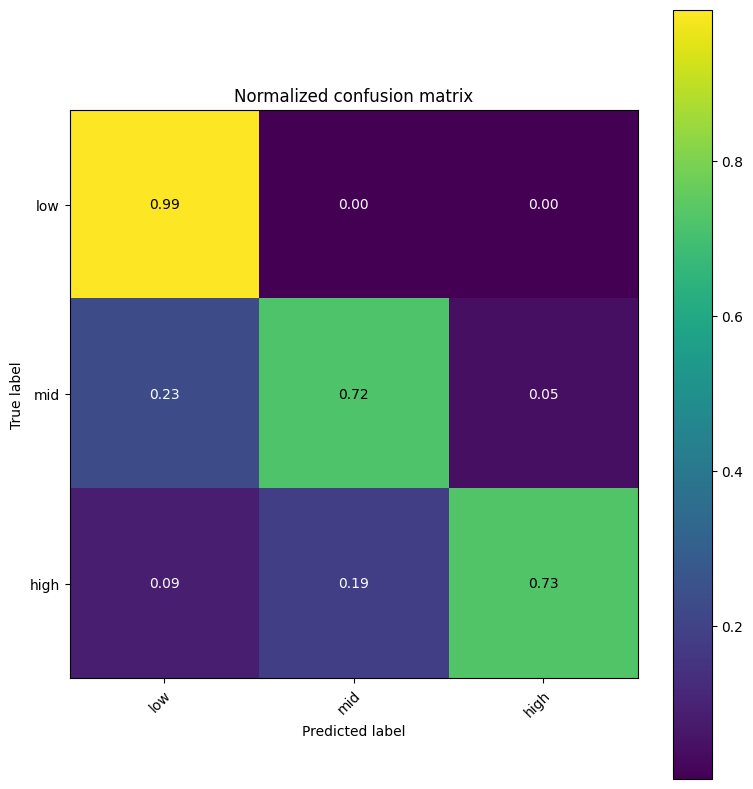

In [12]:
model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=600)
model.fit(train_x, train_y)
y_pred = model.predict(test_x)
class_names = np.array(["low", "mid", "high"] )
plot_conf_mat(test_y, y_pred, class_names)
print("The accuracy is ", accuracy_score(test_y, y_pred) )

Save the model

In [13]:
with open(my_path+"logistic-reg.pkl", "wb") as dump_file:
  pickle.dump(model, dump_file)

# 1st Neural Network

If you use Neural Networks, in Colab do "Runtime > Change Runtime type" to TPU or GPU.

The functions `build_model()` and `train_model(..)` are very similar to what you encountered in the [notebooks on Neural Networks](https://github.com/andreaaraldo/machine-learning-for-networks/tree/master/04.neural_networks).

In [17]:
sample_size = train_x.shape[1]
num_of_classes=len(class_names)

In [21]:
nnfile = nn_file = my_path + 'nn1.h5'

shallow_architecture=[20, 10, 5, num_of_classes]
model = make_sequential_model(sample_size, shallow_architecture,
                              loss_fun="sparse_categorical_crossentropy")


Observe that we have used `sparse_categorical_crossentropy`, which computes `-log(prob)` where  `prob` is the probability of being of the true class

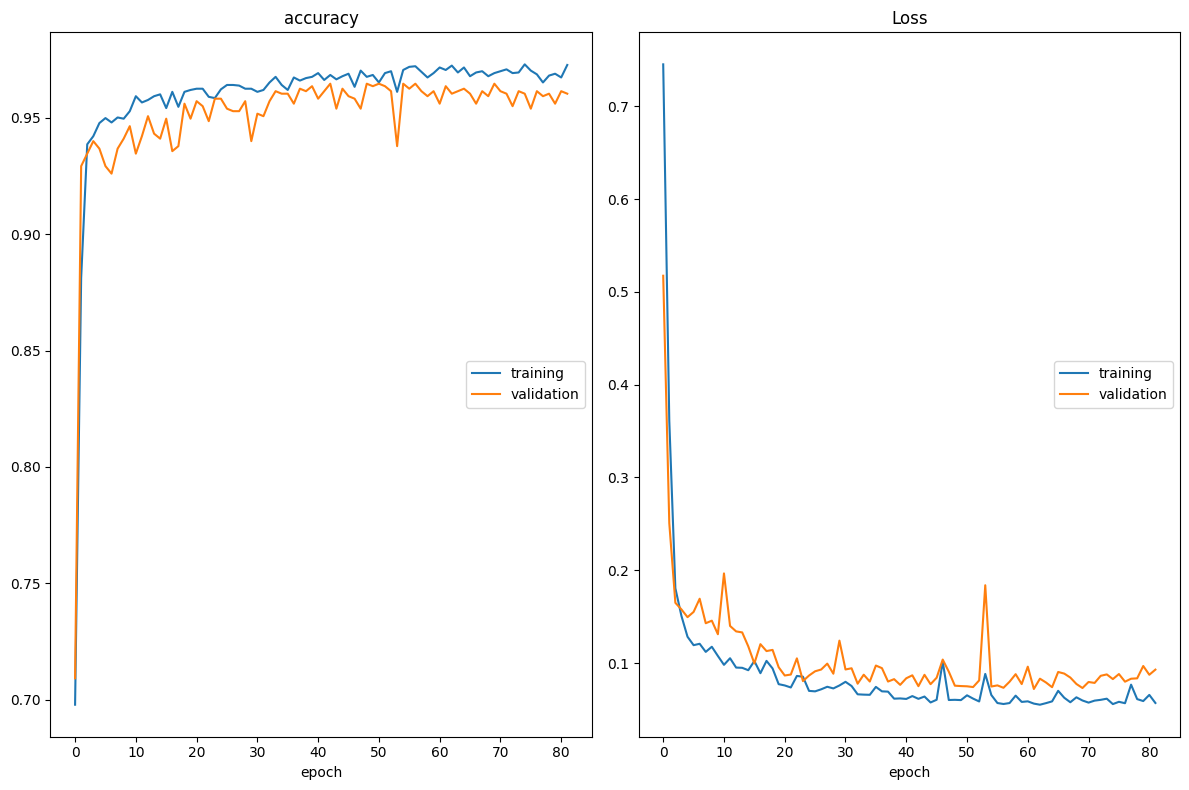

accuracy
	training         	 (min:    0.698, max:    0.973, cur:    0.973)
	validation       	 (min:    0.709, max:    0.965, cur:    0.960)
Loss
	training         	 (min:    0.055, max:    0.745, cur:    0.057)
	validation       	 (min:    0.072, max:    0.517, cur:    0.093)
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9770 - loss: 0.0482 - val_accuracy: 0.9603 - val_loss: 0.0929
Epoch 82: early stopping
Restoring model weights from the end of the best epoch: 62.


In [22]:
history = train_model(model, nn_file, train_x, train_y, seed=3)

In [23]:
print("The trained NN model has been saved to ", nnfile)

The trained NN model has been saved to  /content/gdrive/My Drive/tsp/teaching/data-science-for-networks/img-from-code/09.highspeed-net/nn1.h5


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Normalized confusion matrix
[[0.96551724 0.         0.03448276]
 [0.         0.94067797 0.05932203]
 [0.00921659 0.00460829 0.98617512]]
The accuracy is  0.9656652360515021


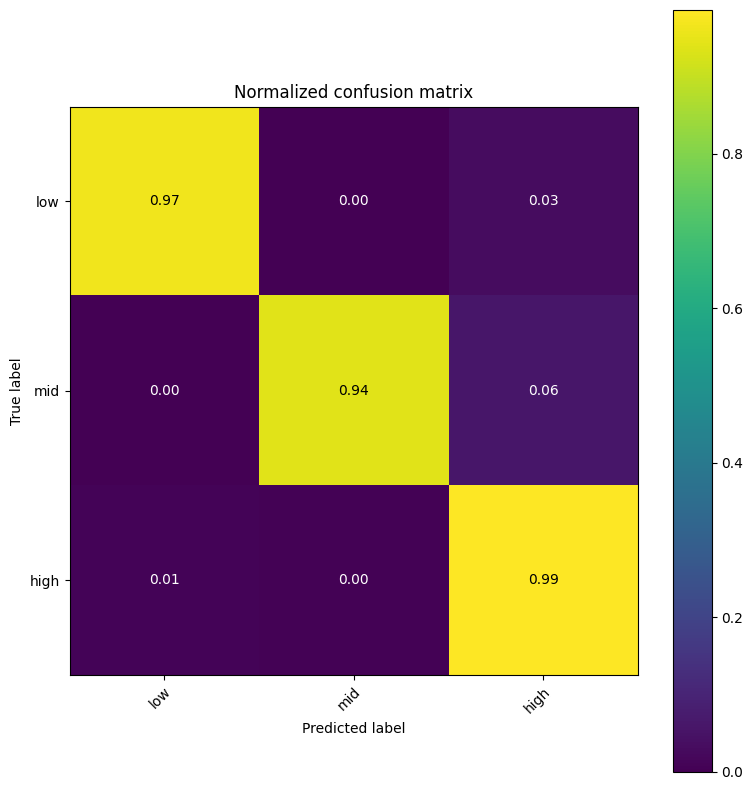

In [24]:
y_pred_ = model.predict(test_x)
y_pred = np.argmax(y_pred_, axis=1)
plot_conf_mat(test_y, y_pred, class_names)
print("The accuracy is ", accuracy_score(test_y, y_pred) )

This NN performs better than the Logistic Regression. However, will it be fast enough to classify at line speed?

You will have to check on the testbed notebook!

# Your model

Train your models here and dump (i.e., save) them.